In [1]:
!python --version

Python 3.10.5


In [2]:
#Preprocessing code borrowed from Fabrizio Ravelli: https://www.kaggle.com/code/fabrizioravelli/alzheimer-s-disease-classification-98-acc

import os
import cv2
import random
from tqdm import tqdm
import pickle

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras.backend as K

from keras import models
from keras import layers
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.models import Model



CLASSES = ("MILD_DEMENTED", "NON_DEMENTED", "VERYMILD_DEMENTED")
DATASET_DIR = "data/"
TEST_DIR = DATASET_DIR + "test/"
TRAINING_DIR = DATASET_DIR + "train/"

IMG_SIZE = 100

def create_data(directory):
    data = []
    for CLASSE in CLASSES:
        path = os.path.join(directory, CLASSE)
        class_num = CLASSES.index(CLASSE)
        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img))
            img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            data.append((img_array, class_num))
            
    return data

train_data = create_data(TRAINING_DIR)
test_data = create_data(TEST_DIR)

random.shuffle(train_data)
random.shuffle(test_data)

def prepare_data(data):
    inp = []
    out = []
    
    for img, label in data:
        inp.append(img)
        y = np.zeros(len(CLASSES))
        y[label] = 1
        out.append(y)
    inp = np.array(inp).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    
    return inp, out

X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

X_train = X_train / 255
y_train = np.array(y_train)

X_test = X_test / 255
y_test = np.array(y_test)

for classe in CLASSES:
    class_num = CLASSES.index(classe)
    print(classe, class_num)


100%|█████████████████| 224/224 [00:00<00:00, 786.42it/s]


MILD_DEMENTED 0
NON_DEMENTED 1
VERYMILD_DEMENTED 2


Text(0.5, 0, 'Mild Demented')

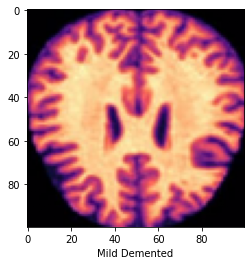

In [3]:
plt.imshow(X_train[6:7][0,:,:,:])
plt.xlabel("Mild Demented")

Text(0.5, 0, 'Very Mild Demented')

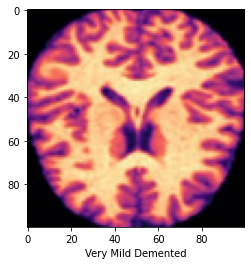

In [4]:
plt.imshow(X_train[37:38][0,:,:,:])
plt.xlabel("Very Mild Demented")

Text(0.5, 0, 'Non Demented')

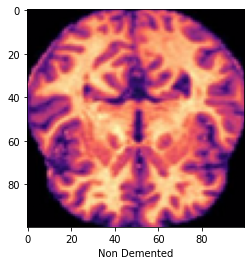

In [5]:
plt.imshow(X_train[65:66][0,:,:,:])
plt.xlabel("Non Demented")

In [6]:
model = models.Sequential([
    layers.Conv2D(512, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', name='last_conv_layer'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(CLASSES), activation='softmax')], name='modelv1')

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc', Precision(name='prec'), Recall(name='rec'), AUC(name='auc')])

model.summary()

Model: "modelv1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 512)       14336     
                                                                 
 average_pooling2d (AverageP  (None, 49, 49, 512)      0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 49, 49, 512)      2048      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 256)       1179904   
                                                                 
 average_pooling2d_1 (Averag  (None, 23, 23, 256)      0         
 ePooling2D)                                                     
                                                           

2022-08-15 13:38:53.838637: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-15 13:38:53.867363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-15 13:38:53.869630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-15 13:38:53.872291: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1)

Epoch 1/100


2022-08-15 13:38:56.620990: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


161/161 [==============================] - 18s 91ms/step - loss: 0.8075 - acc: 0.5941 - prec: 0.6182 - rec: 0.5356 - auc: 0.8069 - val_loss: 3.6013 - val_acc: 0.1351 - val_prec: 0.1351 - val_rec: 0.1351 - val_auc: 0.4552
Epoch 2/100
161/161 [==============================] - 13s 80ms/step - loss: 0.6572 - acc: 0.6544 - prec: 0.6709 - rec: 0.6240 - auc: 0.8592 - val_loss: 1.3565 - val_acc: 0.2175 - val_prec: 0.2560 - val_rec: 0.1491 - val_auc: 0.5451
Epoch 3/100
161/161 [==============================] - 13s 80ms/step - loss: 0.6247 - acc: 0.6598 - prec: 0.6738 - rec: 0.6302 - auc: 0.8684 - val_loss: 1.0160 - val_acc: 0.4246 - val_prec: 0.4818 - val_rec: 0.2789 - val_auc: 0.6525
Epoch 4/100
161/161 [==============================] - 13s 80ms/step - loss: 0.6006 - acc: 0.6680 - prec: 0.6830 - rec: 0.6413 - auc: 0.8779 - val_loss: 0.5235 - val_acc: 0.7404 - val_prec: 0.7561 - val_rec: 0.7123 - val_auc: 0.9127
Epoch 5/100
161/161 [==============================] - 13s 80ms/step - loss: 0.5

In [8]:
test_scores = model.evaluate(X_test, y_test)

print("Testing Loss: %.2f%%"%(test_scores[0] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))
print("Testing Precision: %.2f%%"%(test_scores[2] * 100))
print("Testing Recall: %.2f%%"%(test_scores[3] * 100))
print("Testing AUC: %.2f%%"%(test_scores[4] * 100))


20/20 [==============================] - 1s 42ms/step - loss: 0.6694 - acc: 0.8878 - prec: 0.8878 - rec: 0.8878 - auc: 0.9511
Testing Loss: 66.94%
Testing Accuracy: 88.78%
Testing Precision: 88.78%
Testing Recall: 88.78%
Testing AUC: 95.11%


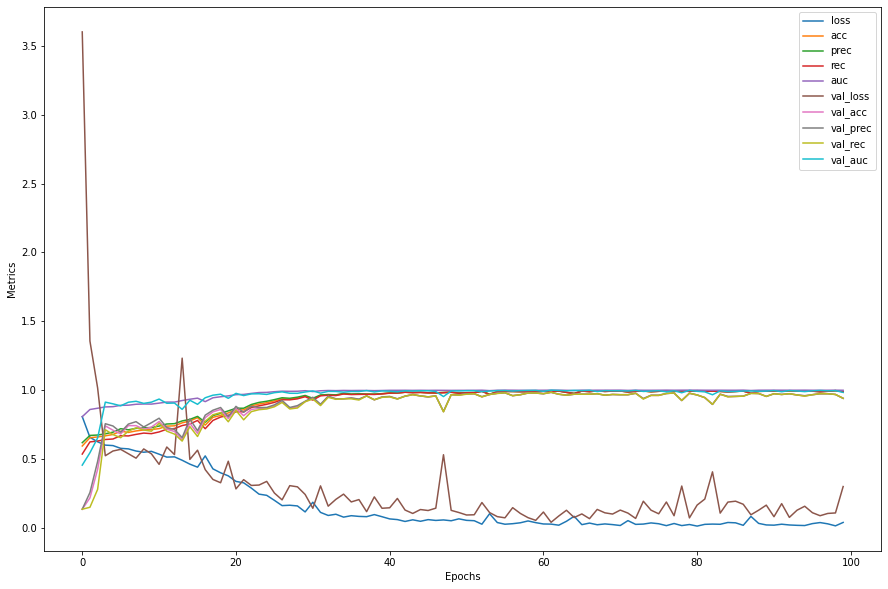

In [9]:
pd.DataFrame(history.history).plot(figsize=(15, 10))
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.show()

In [10]:
loss_history = history.history['val_loss']

In [11]:
min_loss = 100
min_epoch = 0

for i in range(1,51):
    if loss_history[i] < min_loss:
        min_loss = loss_history[i]
        min_epoch = i


In [12]:
min_epoch

50

In [13]:
model = models.Sequential([
    layers.Conv2D(512, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', name='last_conv_layer'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(CLASSES), activation='softmax')], name='modelv1')

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc', Precision(name='prec'), Recall(name='rec'), AUC(name='auc')])

history = model.fit(
    X_train, y_train,
    epochs=min_epoch,
    batch_size=32,
    validation_split=0.01)

Epoch 1/50
177/177 [==============================] - 16s 84ms/step - loss: 0.7890 - acc: 0.5982 - prec: 0.6147 - rec: 0.5477 - auc: 0.8108 - val_loss: 2.5051 - val_acc: 0.1404 - val_prec: 0.1404 - val_rec: 0.1404 - val_auc: 0.4423
Epoch 2/50
177/177 [==============================] - 14s 79ms/step - loss: 0.6494 - acc: 0.6505 - prec: 0.6637 - rec: 0.6152 - auc: 0.8587 - val_loss: 2.9412 - val_acc: 0.1579 - val_prec: 0.1481 - val_rec: 0.1404 - val_auc: 0.4452
Epoch 3/50
177/177 [==============================] - 14s 79ms/step - loss: 0.6263 - acc: 0.6507 - prec: 0.6719 - rec: 0.6181 - auc: 0.8663 - val_loss: 0.6296 - val_acc: 0.5614 - val_prec: 0.5769 - val_rec: 0.5263 - val_auc: 0.8541
Epoch 4/50
177/177 [==============================] - 14s 79ms/step - loss: 0.5948 - acc: 0.6711 - prec: 0.6897 - rec: 0.6434 - auc: 0.8788 - val_loss: 0.4902 - val_acc: 0.7018 - val_prec: 0.7407 - val_rec: 0.7018 - val_auc: 0.9205
Epoch 5/50
177/177 [==============================] - 14s 79ms/step - lo

In [14]:
test_scores = model.evaluate(X_test, y_test)

print("Testing Loss: %.2f%%"%(test_scores[0] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))
print("Testing Precision: %.2f%%"%(test_scores[2] * 100))
print("Testing Recall: %.2f%%"%(test_scores[3] * 100))
print("Testing AUC: %.2f%%"%(test_scores[4] * 100))

20/20 [==============================] - 0s 20ms/step - loss: 0.2349 - acc: 0.9494 - prec: 0.9494 - rec: 0.9494 - auc: 0.9849
Testing Loss: 23.49%
Testing Accuracy: 94.94%
Testing Precision: 94.94%
Testing Recall: 94.94%
Testing AUC: 98.49%
